<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 7.  Финальное задание и Соревнование Kaggle "Catch Me If You Can"
    
Задача сделать детальный анализ данных и получить максимальный бал в этом соревновании который получится.

In [4]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
scipy 0.19.1
pandas 0.24.2
matplotlib 3.1.1
statsmodels 0.8.0
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : 7c380f689acd8773171e8df2db07296789494474


In [5]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
import matplotlib
print(pd.__version__)
print(matplotlib.__version__)

0.24.2
3.1.1


In [7]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'kaggle'

In [8]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [9]:
%%time
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), 
                       index_col='session_id', parse_dates = times)
train_df.fillna({site:0 for site in sites}, inplace = True)

# let's not sort immediately and see how it affects model results later
#train.sort_values(by='time1', inplace=True)

test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates = times)
test_df.fillna({site:0 for site in sites}, inplace = True)

Wall time: 4.56 s


In [10]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,0.0,NaT,0.0,NaT,0.0,NaT,...,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,0.0,NaT,...,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0.0,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Check that no targets are missing. Number of missing values:  0 0 0
Value counts for target:
0    251264
1      2297
Name: target, dtype: int64


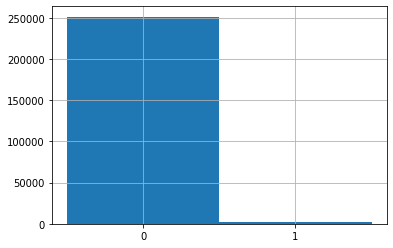

In [11]:
print("Check that no targets are missing. Number of missing values: ", 
      train_df.target.isna().sum(), len(train_df[train_df.site1 == 0]), train_df.time1.isna().sum())
print("Value counts for target:")
print(train_df.target.value_counts())
ax = train_df.target.hist(bins=range(3))
ax.set_xticks(np.arange(2) + 0.5)
_ = ax.set_xticklabels(range(2))

According to the target class labels we are going to deal with unbalanced binary classification. It might be a good idea to try different options to either balance the data (bootstrap or SMOTE or stratification if applies, in other words downsampling/upsampling) or penalize errors on minor class and use the correct metric (accuracy is not the one). 

# Feature extraction

For now the point is to extract as much features as possible and explore.

In [7]:
# create a shallow copy
train_extended_df = train_df.copy(deep=False)

In [187]:
# time delta to be used to see how much time the session takes
train_extended_df['time_delta'] = (train_df[times].max(axis=1) - train_df[times].min(axis=1))
train_extended_df['time_delta_minutes'] = train_extended_df.time_delta.astype('timedelta64[m]')
train_extended_df['time_delta_seconds'] = train_extended_df.time_delta.astype('timedelta64[s]')

In [9]:
from datetime import datetime

time_pattern = '%Y-%m-%d %H:%M:%S'
feature_names = ['start_day', 'start_month', 'start_hour', 'start_minutes', 'end_hour', 'end_minutes', 'weekend']
def extract_features(row):
    start_dt = row.time1
    end_dt = row[row[times].last_valid_index()]
    day_of_week = start_dt.weekday()
    weekend = 1 if day_of_week in [5,6] else 0
    return day_of_week, start_dt.month, start_dt.hour, start_dt.minute, end_dt.hour, end_dt.minute, weekend

In [10]:
%%time
train_extended_df[feature_names] = train_df.apply(extract_features, axis=1, result_type='expand', raw=True)

Wall time: 5min 27s


In [11]:
train_extended_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time10,target,time_delta,start_day,start_month,start_hour,start_minutes,end_hour,end_minutes,weekend
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0.0,NaT,0.0,NaT,0.0,NaT,0.0,NaT,...,NaT,0,00:00:00,3,2,10,2,10,2,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:20:16,0,00:00:26,5,2,11,19,11,20,1
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:24,0,00:00:07,0,12,16,40,16,40,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:56:42,0,00:04:30,4,3,10,52,10,56,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:57:11,0,00:04:06,4,2,10,53,10,57,0


In [283]:
hosts = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_dic.pkl'))
idToHost = {v:k for k,v in hosts.items()}

In [13]:
sorted(hosts, key=lambda x: x[::-1]) #key function is reverse of the string, no built-in reverse

['87.98.128.200',
 '79.98.96.110',
 '91.121.182.20',
 '193.164.196.30',
 '193.164.197.30',
 '143.127.102.40',
 '193.164.196.40',
 '193.164.197.40',
 '193.164.196.50',
 '193.164.197.50',
 '193.164.196.60',
 '193.164.197.60',
 '188.165.255.70',
 '203.141.205.180',
 '46.28.49.180',
 '60.33.230.11',
 '5.135.140.211',
 '115.30.191.21',
 '206.128.127.131',
 '46.105.57.81',
 '85.214.84.91',
 '178.75.164.191',
 '37.252.232.2',
 '83.206.13.2',
 '67.53.48.2',
 '176.58.127.102',
 '178.33.227.102',
 '203.112.63.12',
 '202.183.54.12',
 '78.116.39.212',
 '37.252.230.22',
 '94.23.236.222',
 '116.193.97.222',
 '69.195.124.152',
 '91.121.97.162',
 '83.206.219.162',
 '128.101.105.82',
 '37.252.232.3',
 '5.9.139.3',
 '178.255.153.13',
 '59.146.77.13',
 '85.17.77.13',
 '188.138.10.213',
 '202.183.63.213',
 '213.30.164.213',
 '210.128.81.133',
 '66.70.56.43',
 '93.93.190.243',
 '92.113.35.53',
 '160.92.123.193',
 '217.146.14.4',
 '210.167.76.204',
 '91.121.134.14',
 '208.74.204.114',
 '37.252.230.24',
 '62

It seems like most of the sites have 3 domain levels. Also, domain zone might be an interesting feature, I don't think users usually visit domains in multiple zones. Let's quickly investigate that.

In [14]:
np.bincount([x.count('.') for x in hosts])

array([    0,  3573, 31253, 12118,  1192,   149,    18,    57,     3,
           6,     0,     0,     0,     2], dtype=int64)

Right, most of the sites have 1,2 or 3 sub domains.

In [15]:
site_id_zone = { site_id:host[host.rfind('.') + 1:] for host, site_id in hosts.items() }
site_id_zone

{25075: 'com',
 13997: 'com',
 42436: 'com',
 30911: 'eu',
 8104: 'eu',
 37491: 'us',
 5462: 'fr',
 35425: 'be',
 30151: 'com',
 38268: 'com',
 43641: 'com',
 36959: 'ca',
 40935: 'ca',
 12346: 'net',
 31023: 'com',
 31114: 'com',
 28165: 'net',
 31877: 'fr',
 31070: 'com',
 12938: 'net',
 42002: 'net',
 5671: 'com',
 32074: 'ch',
 7104: 'com',
 1939: 'net',
 6708: 'com',
 43589: 'fr',
 45241: 'com',
 16195: 'fr',
 23921: 'com',
 28449: 'com',
 14139: 'net',
 7082: 'com',
 46081: 'net',
 2599: 'fr',
 46307: 'tv',
 21319: 'org',
 3282: 'com',
 45634: 'com',
 28768: 'com',
 5451: 'fr',
 6185: 'fr',
 47973: 'net',
 31500: 'com',
 46861: 'net',
 40008: 'jp',
 437: 'com',
 17157: 'com',
 19864: 'net',
 28747: 'com',
 34741: 'ch',
 30461: 'com',
 2321: 'fr',
 44216: 'com',
 22894: 'com',
 48066: 'ru',
 43454: 'com',
 40738: 'org',
 12037: 'com',
 34376: 'net',
 18052: 'net',
 30498: 'com',
 31715: 'net',
 32389: 'com',
 45741: 'nl',
 34839: 'com',
 5305: 'net',
 10938: 'com',
 32449: 'com',


In [16]:
# it might be better to introduce feature for each zone and go through all 10 sites to put 1 or 0 in corresponding zone
train_extended_df['zone'] = train_extended_df.site1.apply(lambda x: site_id_zone[x])
train_extended_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,target,time_delta,start_day,start_month,start_hour,start_minutes,end_hour,end_minutes,weekend,zone
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0.0,NaT,0.0,NaT,0.0,NaT,0.0,NaT,...,0,00:00:00,3,2,10,2,10,2,0,com
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,0,00:00:26,5,2,11,19,11,20,1,com
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,0,00:00:07,0,12,16,40,16,40,0,com
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,0,00:04:30,4,3,10,52,10,56,0,org
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,0,00:04:06,4,2,10,53,10,57,0,com


# Visualizing the data

## Site zones

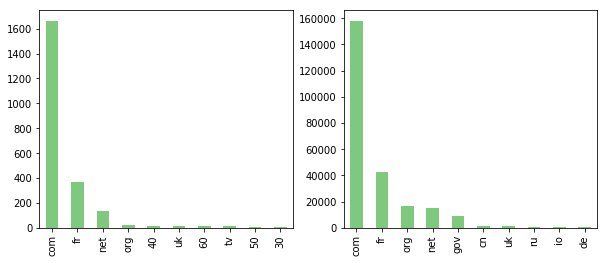

In [345]:
alisa_zone_counts = train_extended_df[train_extended_df.target == 1].zone.value_counts()
other_zone_counts = train_extended_df[train_extended_df.target == 0].zone.value_counts()

fig, axes = plt.subplots(1,2, figsize=(10,4))

alisa_zone_counts.nlargest(10).plot(kind='bar', colormap='Accent', ax=axes[0])
other_zone_counts.nlargest(10).plot(kind='bar', colormap='Accent', ax=axes[1])

Seems like zone can be useful sometimes, but at the same time most people in the dataset are using com, fr, net, org zones. Alisa doesn't use gov sites which might be useful to detect if it's NOT Alice.

## Session duration

(-20, 300)

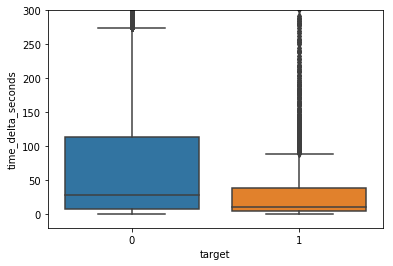

In [176]:
axes = sns.boxplot(x='target', y='time_delta_seconds', data=train_extended_df)
axes.set_ylim(-20, 300)

Even though Alise sessions are shorter than for others, the numbers are really weird. Most of the sessions take less than ~1 minute. What's possible to read for one minute? Especially, if you open 10 sites for the session. I would use this feature very carefully.
And the values should be normalized.

## Day of week

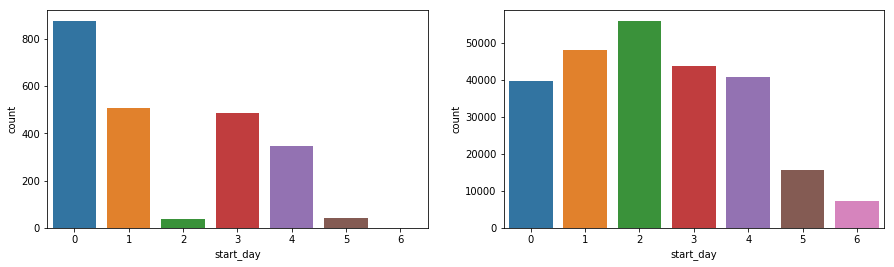

In [196]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.countplot(x="start_day", data=train_extended_df[train_extended_df.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_day", data=train_extended_df[train_extended_df.target==0], ax=axes[1]) # Not Alice

Alisa has special days, should be a really useful feature. Note: it's categorical, so will have to be one-hot encoded (or any other encoding useful for model)

## Month

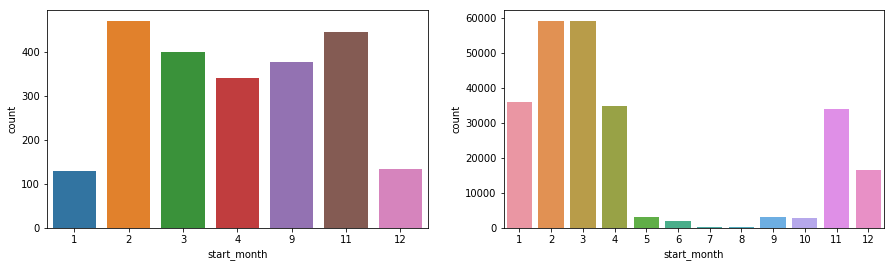

In [205]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.countplot(x="start_month", data=train_extended_df[train_extended_df.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_month", data=train_extended_df[train_extended_df.target==0], ax=axes[1]) # Not Alice

Alisa doesn't have any visits on 6,7,8 month, should be a really useful feature. Note: it's categorical, so will have to be one-hot encoded (or any other encoding useful for model)

## Start hour

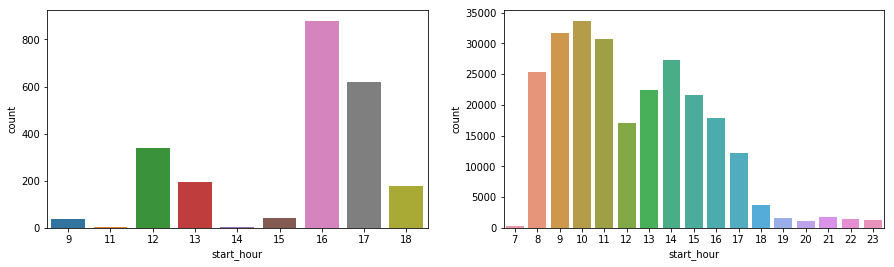

In [206]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.countplot(x="start_hour", data=train_extended_df[train_extended_df.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_hour", data=train_extended_df[train_extended_df.target==0], ax=axes[1]) # Not Alice

Yet another useful feature, categorical as well, so has to be encoded

## Start minute

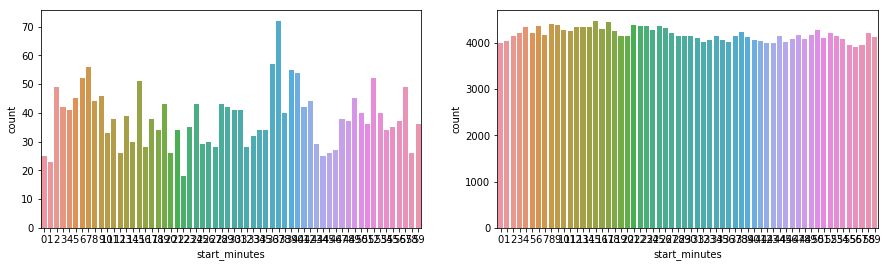

In [211]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.countplot(x="start_minutes", data=train_extended_df[train_extended_df.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_minutes", data=train_extended_df[train_extended_df.target==0], ax=axes[1]) # Not Alice

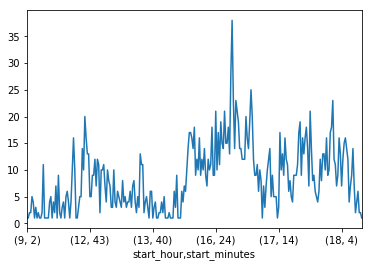

In [227]:
ax = train_extended_df[train_extended_df.target==1].reset_index().groupby(['start_hour','start_minutes'])[['session_id']].count()['session_id'].plot()

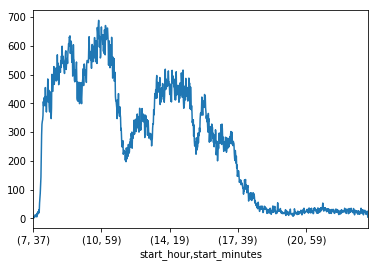

In [228]:
ax = train_extended_df[train_extended_df.target==0].reset_index().groupby(['start_hour','start_minutes'])[['session_id']].count()['session_id'].plot()

Well, minutes feature by itself dosen't look promissing, it's close to be evenly distributed. But looking at hour,minute pair it seems to be also evenly distributed by hour. There can be some information in this feature, but I would'n use it until necessary. Especially when it's a categorical feature with 60 values and if we multiply by 24 hours, it's 60*24=1440 hot-encoded features. I would rather group minutes by 10 to reduce the space and make hours feature more fine grained.

That said, we can try to use approach where instead of hours(0 to 24) we will use half-hours (0 to 48) or quater hours (0 to 96).

## End hour and End minutes

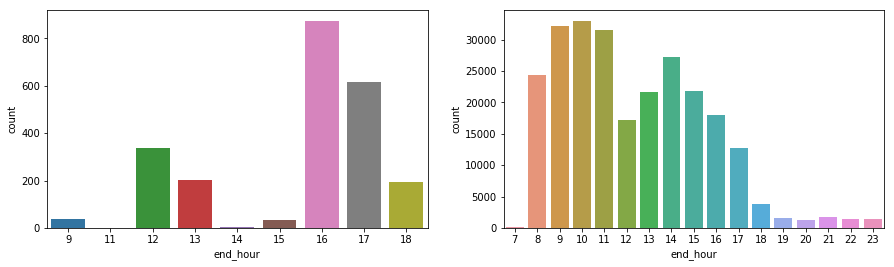

In [230]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.countplot(x="end_hour", data=train_extended_df[train_extended_df.target==1], ax=axes[0]) # Alice
sns.countplot(x="end_hour", data=train_extended_df[train_extended_df.target==0], ax=axes[1]) # Not Alice

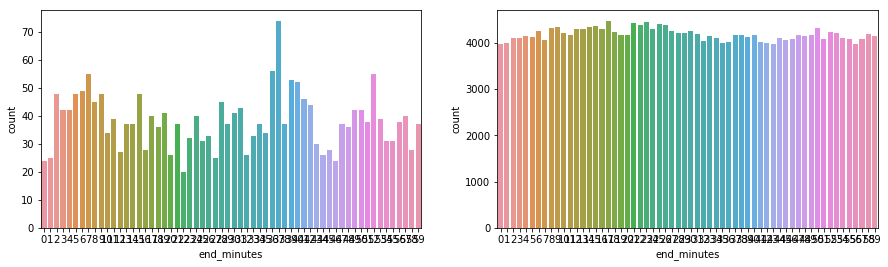

In [231]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.countplot(x="end_minutes", data=train_extended_df[train_extended_df.target==1], ax=axes[0]) # Alice
sns.countplot(x="end_minutes", data=train_extended_df[train_extended_df.target==0], ax=axes[1]) # Not Alice

As expected, since the sessions are quite short (10 minutes), end times match the begin times. I wouldn't use such a feature.
I think combination of start + duration of session makes more sense here. At the same time duration also doesn't look promissing.

## Weekend

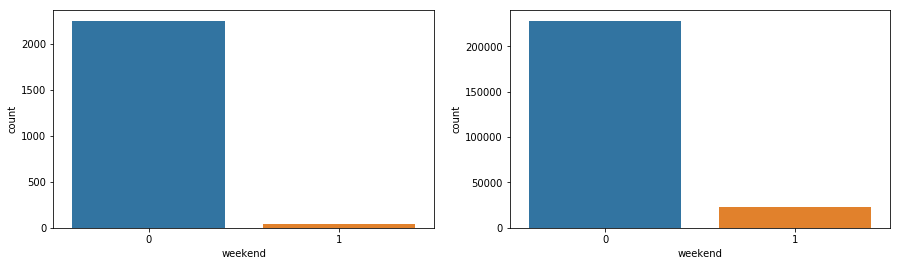

In [232]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.countplot(x="weekend", data=train_extended_df[train_extended_df.target==1], ax=axes[0]) # Alice
sns.countplot(x="weekend", data=train_extended_df[train_extended_df.target==0], ax=axes[1]) # Not Alice

Alisa has very little sessions on weekend, but if we look at days charts, we will see the same picture, moreover there are some sessions on saturday, but none on sundays, so we could've introduced isSunday feature. But it will be the same as if we hot-encode the days.. So, this feature is useless. Hot-encoding days will be good enough.

## Alisa sites

Let's visualize a site frequences for sites visited by Alisa only. We will not use it as a feature for model, but rather for interprete the results of linear models trained on the data.

''

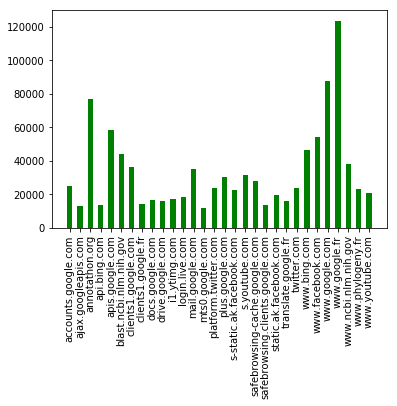

In [360]:
from collections import Counter
from pandas import DataFrame

site_ids = train_df[sites].astype(int).values.reshape(-1)
cnt = Counter([idToHost[int(site_id)] for site_id in site_ids if site_id != 0])
del cnt[0]
alisa_top_sites = sorted(cnt.most_common(30), key=lambda x: x[1])
plt.bar(*zip(*alisa_top_sites), width=.5, color='g')
plt.xticks(rotation='vertical')
;

Surprisingly, there are not only com and org sites in this hot list but 'gov' sites as well. Previously, we thought that Alisa doesn't visit gov sites at all. That's not true. We took only first site zone previously, but seems like other site zones are importnat too. I would say, that instead of looking at site ids, we should instead look at (3rd level, 2nd level, 1st level/zone)

In [380]:
print(cnt['vk.com'], cnt['youwatch.org'], cnt['fr.msn.com'], cnt['www.video.tt'], cnt['youtube.com'])

1321 227 1442 30 53


# Models evaluation

In [356]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

At first, let's ignore CV at all and do a couple of submissions by training classifiers as is.

In [294]:
%%time
# at first take sites only
y = train_df.target.values
len(y)

# concat train and test as they need to be pre-processed same way
train_test_df = pd.concat([train_df, test_df], sort=False)
train_test_df_sites = train_test_df[sites].astype('int')
train_test_df_sites['word'] = train_test_df_sites.astype(np.str).apply(' '.join, axis=1)

# sites need to be vectorized into sparse matrix, so each site is a feature
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_test_df_sites['word'])

X_train_sparse = X[:len(train_df)]
X_test_sparse = X[len(train_df):]

print(X_train_sparse.shape, X_test_sparse.shape)

(253561, 48362) (82797, 48362)
Wall time: 13.6 s


In [240]:
# interesting fact which everybody can miss, by default count vectorizer collects only words with more than one character
# so site ids below 10 are completely skipped
site_feature_names = set(vectorizer.get_feature_names())
for site_id in range(15):
    print(str(site_id) in site_feature_names)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


Let's train SGDClassifier and submit for a baseline

In [262]:
def baseline(name, train, y):
    sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
    sgd_logit.fit(train, y)
    logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)
    write_to_submission_file(logit_test_pred_proba[:,1], os.path.join(PATH_TO_DATA, name))
    return sgd_logit

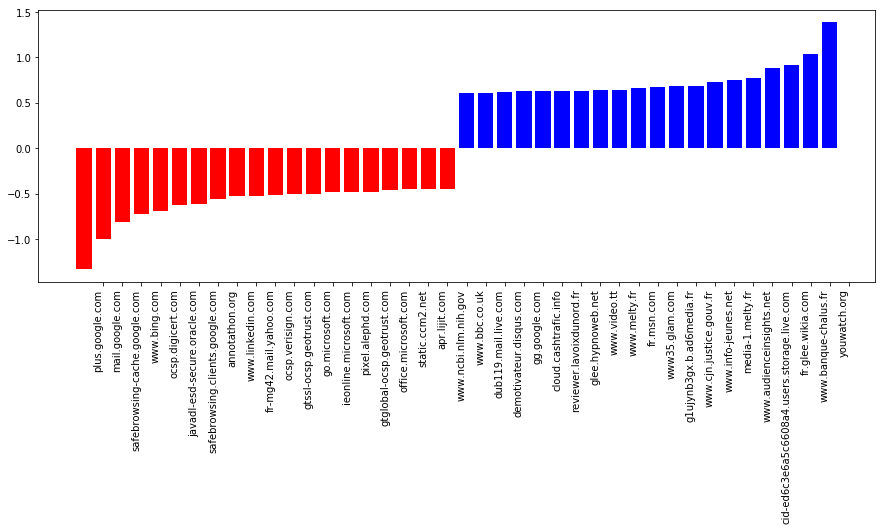

Wall time: 1.35 s


In [295]:
%%time
sgd_logit = baseline('final-baseline.csv', X_train_sparse, y)
plot_coefficients(sgd_logit, vectorizer.get_feature_names())

In [245]:
SCORES = []
SCORES.append(0.91234)

Let's fix CountVectorizer for 0 and 10

In [361]:
%%time
vectorizer = CountVectorizer(stop_words=['0'], token_pattern="\d+")
X = vectorizer.fit_transform(train_test_df_sites.to_string(index=False, header=False).splitlines())

X_train_sparse = X[:len(train_df)]
X_test_sparse = X[len(train_df):]

print(X_train_sparse.shape, X_test_sparse.shape)

(253561, 48371) (82797, 48371)
Wall time: 29 s


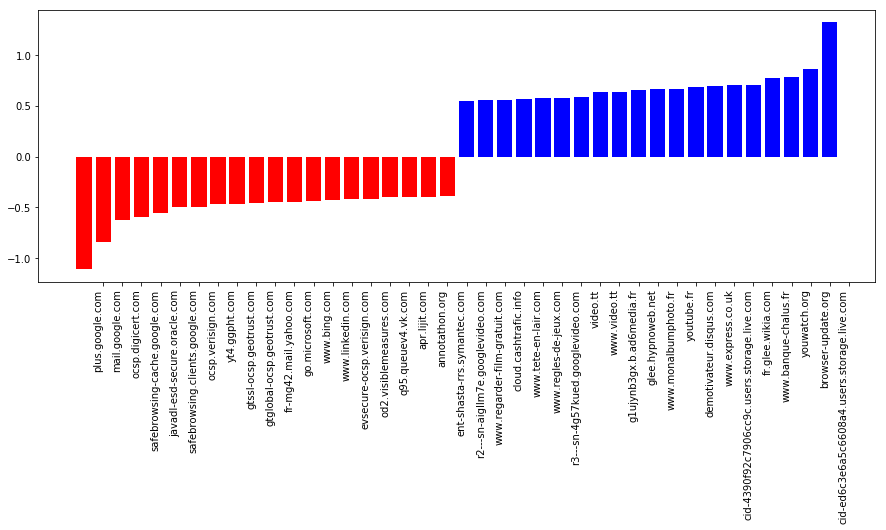

Wall time: 1.34 s


In [362]:
%%time
sgd_logit2 = baseline('final-baseline2.csv', X_train_sparse, y)
plot_coefficients(sgd_logit2, vectorizer.get_feature_names())

Yet another interesting fact, that almost none of the top visited by Alisa sites are present in the top coefficients of model..
The sites which ARE there have negative coefficients, how is that possible? Is it because too much people are visiting them as well?

In [246]:
SCORES.append(0.91273)

Quality has incresed, but not much. Let's try to sort the data by time and see if it changes the result anyhow.

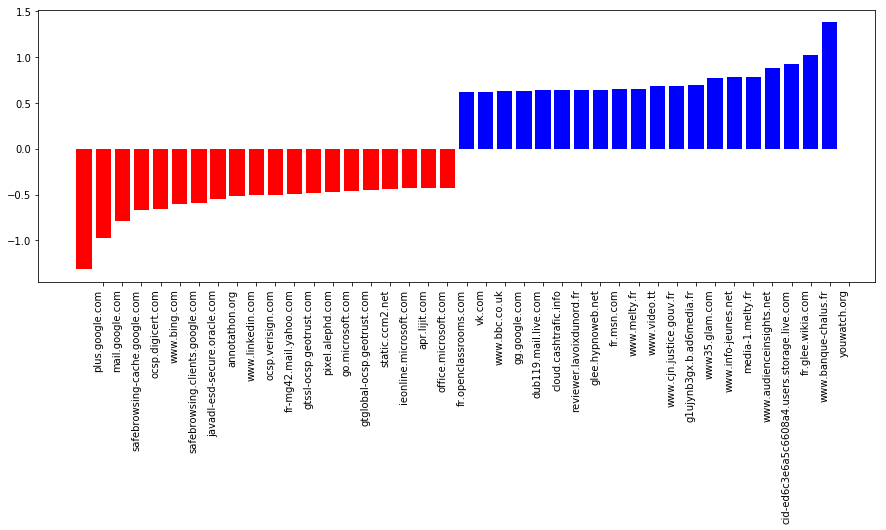

Wall time: 20.5 s


In [363]:
%%time
train_sorted_df = train_df.sort_values(by='time1', inplace=False)
y_sorted = train_sorted_df.target.values
train_test_sorted_df = pd.concat([train_sorted_df, test_df], sort=False)
train_test_sorted_df_sites = train_test_sorted_df[sites].astype('int')

# sites need to be vectorized into sparse matrix, so each site is a feature
vectorizer = CountVectorizer(stop_words=['0'], token_pattern="\d+")
X2 = vectorizer.fit_transform(train_test_sorted_df_sites.to_string(index=False, header=False).splitlines())

X_train_sorted_sparse = X2[:len(train_sorted_df)]
X_test_sparse = X2[len(train_sorted_df):]
sgd_logit3 = baseline('final-baseline3.csv', X_train_sorted_sparse, y_sorted)
plot_coefficients(sgd_logit3, vectorizer.get_feature_names())

In [257]:
SCORES.append(0.91249)

Quality droppend a bit, that's what I would expect for site only features. I believe it will make significant difference when we include time based features later. For now, let's try CountVectorizer with ngrams and TfIdfVectorizer.

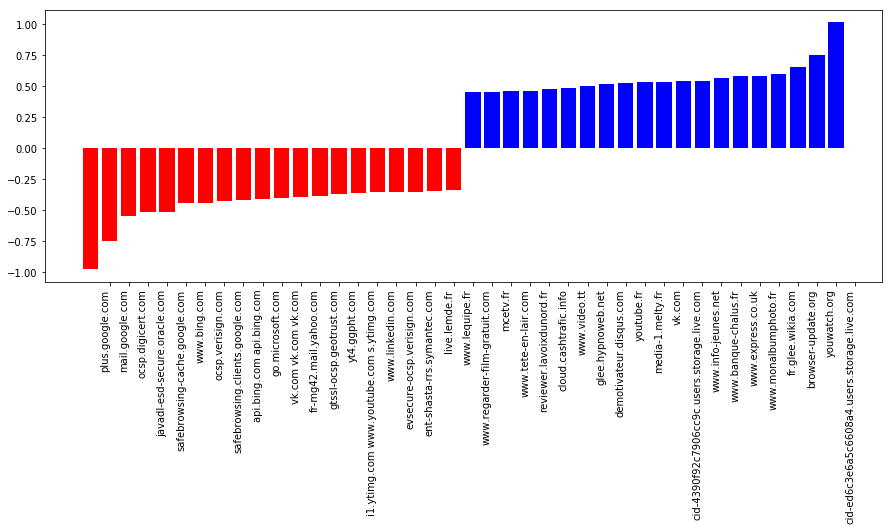

Wall time: 50.4 s


In [373]:
%%time
vectorizer = CountVectorizer(stop_words=['0'], token_pattern="\d+", ngram_range=(1,3))
X = vectorizer.fit_transform(train_test_df_sites.to_string(index=False, header=False).splitlines())

X_train_sparse = X[:len(train_df)]
X_test_sparse = X[len(train_df):]
sgd_logit4 = baseline('final-ngrams1.csv', X_train_sparse, y)
plot_coefficients(sgd_logit4, vectorizer.get_feature_names())

In [259]:
SCORES.append(0.91898)

Quality increased a bit, but I would expect more from doing this. 
Also vk.com with positive coefficient and tripple vk.com with negative coefficient looks weird. Triple grams seems to produce overfitted model for some of the site combinations.
Let's switch to TfIdf.

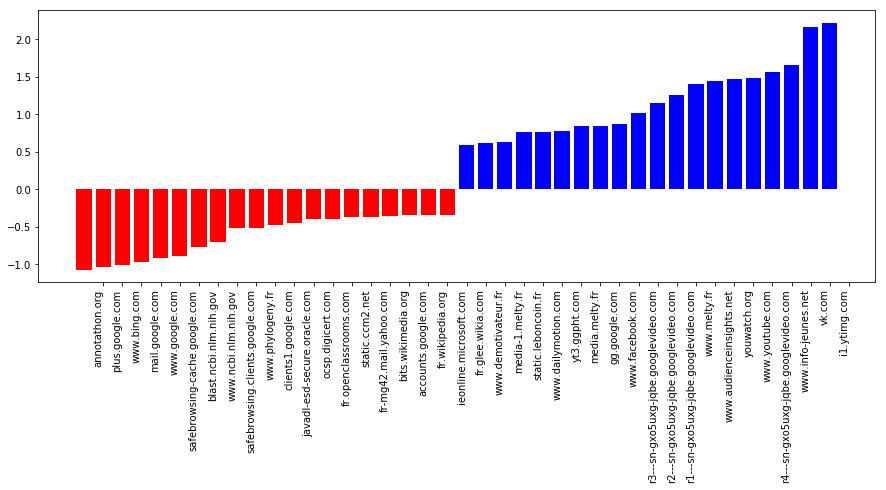

Wall time: 27.1 s


In [374]:
%%time
vectorizer = TfidfVectorizer(stop_words=['0'], token_pattern="\d+")
X = vectorizer.fit_transform(train_test_df_sites.to_string(index=False, header=False).splitlines())

X_train_sparse = X[:len(train_df)]
X_test_sparse = X[len(train_df):]
sgd_logit5 = baseline('final-tfidf1.csv', X_train_sparse, y)
plot_coefficients(sgd_logit5, vectorizer.get_feature_names())

In [261]:
SCORES.append(0.89197)

Quality dropped. Again, that's something unexpected as many people can visit google.com and that site id in a vector shouldn't point to Alisa with big weight. I.e. only unique/rare sites which Alisa visits should point to her. Maybe we should try to add ngrams before switching back to CountVectorizer.

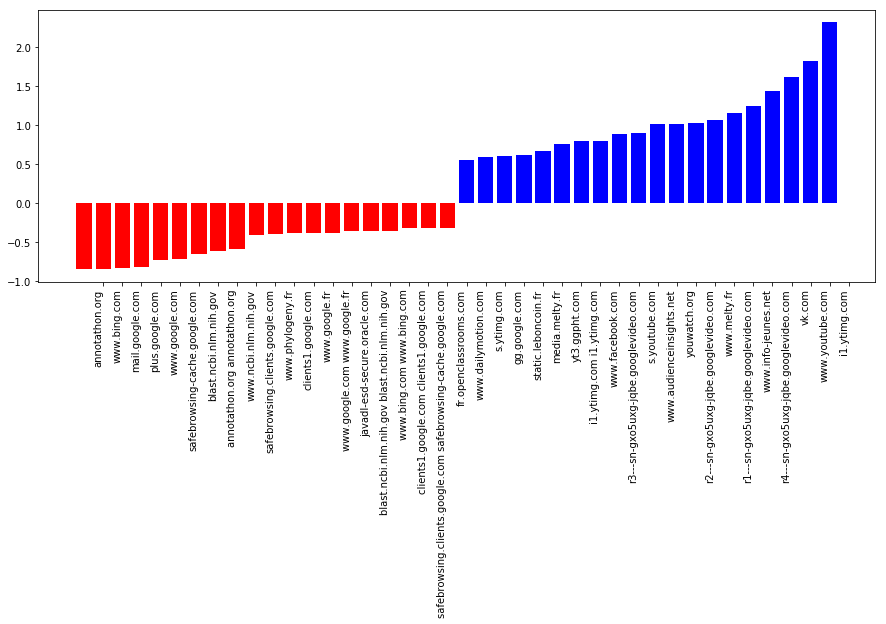

Wall time: 34.5 s


In [379]:
%%time
vectorizer = TfidfVectorizer(stop_words=['0'], token_pattern="\d+", ngram_range=(1,2))
X = vectorizer.fit_transform(train_test_df_sites.to_string(index=False, header=False).splitlines())

X_train_sparse = X[:len(train_df)]
X_test_sparse = X[len(train_df):]
sgd_logit6 = baseline('final-tfidf-ngrams12.csv', X_train_sparse, y)
plot_coefficients(sgd_logit6, vectorizer.get_feature_names())

In [382]:
SCORES.append(0.88808)

To be honest, I really don't like all those models, coefficients are really odd and the model answers are close to a model which always answers "not Alisa" because dataset is significantly unbalanced.

## Cross validation

Since we have a time-series based data, let's use sorted by time1 data and use appropriate model for cross validation.
TimeSeriesSplit.

In [398]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, validation_curve, learning_curve

In [394]:
%%time
train_sorted_df = train_df.sort_values(by='time1', inplace=False)
y_sorted = train_sorted_df.target.values
train_test_sorted_df = pd.concat([train_sorted_df, test_df], sort=False)
train_test_sorted_df_sites = train_test_sorted_df[sites].astype('int')
train_test_sorted_df_sites['word'] = train_test_sorted_df_sites.astype(np.str).apply(' '.join, axis=1)

# sites need to be vectorized into sparse matrix, so each site is a feature
vectorizer = CountVectorizer(stop_words=['0'], token_pattern="\d+")
X2 = vectorizer.fit_transform(train_test_sorted_df_sites.word)

X_train_sorted_sparse = X2[:len(train_sorted_df)]
X_test_sparse = X2[len(train_sorted_df):]

Wall time: 12.5 s


In [395]:
train_test_sorted_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,word
session_id,,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0,56 55 0 0 0 0 0 0 0 0
54843,56,55,56,55,0,0,0,0,0,0,56 55 56 55 0 0 0 0 0 0
77292,946,946,951,946,946,945,948,784,949,946,946 946 951 946 946 945 948 784 949 946
114021,945,948,949,948,945,946,947,945,946,946,945 948 949 948 945 946 947 945 946 946
146670,947,950,948,947,950,952,946,951,946,947,947 950 948 947 950 952 946 951 946 947


In [422]:
cv = TimeSeriesSplit(n_splits=5)

In [423]:
model = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
cv_scores = cross_val_score(model, X_train_sorted_sparse, y_sorted, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores, cv_scores.mean()

(array([0.67663375, 0.80291782, 0.88289819, 0.83510063, 0.90140377]),
 0.8197908330711634)

## Additional Features

In [434]:
def train_test(train_in, test_in, additional_features):
    train_out = hstack([train_in, additional_features[:len(train_sorted_df)]], format='csr')
    test_out = hstack([test_in, additional_features[len(train_sorted_df):]], format='csr')
    return train_out, test_out

In [438]:
def fit_and_submit(model, train, y, test, name='submit.csv'):
    model.fit(train, y)
    pred_proba = model.predict_proba(test)
    write_to_submission_file(pred_proba[:,1], os.path.join(PATH_TO_DATA, name))

Let's add zone of the first site and see if it changes the result anyhow.

In [451]:
additional_features = pd.DataFrame(index=train_test_sorted_df_sites.index)
additional_features['zone'] = train_test_sorted_df_sites.site1.apply(lambda x: site_id_zone[x])
additional_features.head()

,zone
session_id,
21669,com
54843,com
77292,org
114021,com
146670,com


In [452]:
zone_features = pd.get_dummies(additional_features, ['zone'])
train, test = train_test(X_train_sorted_sparse, X_test_sparse, zone_features)
print(train.shape, test.shape)

(253561, 48536) (82797, 48536)


In [439]:
cv_scores = cross_val_score(model, train, y_sorted, cv=cv, scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

[0.68245147 0.80257057 0.87069888 0.8320236  0.89024678] 0.8155982597159352


In [445]:
fit_and_submit(model, train, y_sorted, test, name="final-zones.csv")
SCORES.append(0.90450)

In [453]:
from datetime import datetime

def extract_features(row):
    start_dt = row.time1
    return start_dt.hour, start_dt.weekday(), start_dt.month

In [456]:
additional_features['start_hour'], additional_features['start_day'], additional_features['start_month'] = zip(*train_test_sorted_df.apply(extract_features, axis=1))

categorical_columns = ['start_hour', 'start_day', 'start_month']
start_time_features = pd.get_dummies(additional_features[categorical_columns], columns=categorical_columns)
start_time_features.head()

,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,...,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12
session_id,,,,,,,,,,,,,,,,,,,,,
21669,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54843,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77292,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114021,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146670,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [457]:
train, test = train_test(X_train_sorted_sparse, X_test_sparse, start_time_features)
print(train.shape, test.shape)

(253561, 48407) (82797, 48407)


In [466]:
cv_scores = cross_val_score(model, train, y_sorted, cv=cv, scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

fit_and_submit(model, train, y_sorted, test, name="final-start-time.csv")

[0.79326307 0.8864886  0.97358603 0.96446112 0.96890389] 0.9173405432554652


In [ ]:
SCORES.append(0.93293)

That is quite good score and it happens because time information is very important and helps to recognize Alisa better.

In [468]:
# time delta to be used to see how much time the session takes
additional_features['session_span'] = (train_test_sorted_df[times].max(axis=1) - train_test_sorted_df[times].min(axis=1))
additional_features['session_span_seconds'] = additional_features.session_span.astype('timedelta64[s]')
additional_features.head()

,zone,start_hour,start_day,start_month,session_span,session_span_seconds
session_id,,,,,,
21669,com,8,5,1,00:00:00,0.0
54843,com,8,5,1,00:29:46,1786.0
77292,org,8,5,1,00:00:04,4.0
114021,com,8,5,1,00:00:03,3.0
146670,com,8,5,1,00:00:02,2.0


In [477]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
session_span_normalized = pd.DataFrame(min_max_scaler.fit_transform(additional_features[['session_span_seconds']]),columns=['session_span_seconds'])
session_span_normalized.head()

,session_span_seconds
0,0.000000
1,0.992222
2,0.002222
3,0.001667
4,0.001111


In [478]:
train, test = train_test(train, test, session_span_normalized)
print(train.shape, test.shape)

(253561, 48408) (82797, 48408)


In [479]:
cv_scores = cross_val_score(model, train, y_sorted, cv=cv, scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

fit_and_submit(model, train, y_sorted, test, name="final-time-and-duration.csv")

[0.79365491 0.88747971 0.97393473 0.96478044 0.96917275] 0.9178045103723725


In [480]:
SCORES.append(0.93338)

## Result

The model chosen for the final score is quite generic and doesn't have much of a hardcode features for Alisa. Instead of introducing features specific to the patterns we saw for Alisa like "no sessions on Sunday", the model trains itself by a one-hot endoded day of week feature. The same for the rest of the features.

At the same time there is still a room for improvement, I wish to try splitting sites on domains and sub domains and make time features more fine grained, i.e. instead of hours or hours and minutes to use half or quater hours.

I also think that TfIdf should work better than CountVectorizer here and have no idea why it was so bad for this competition.

Overall, I don't think this model is very useful in practice. 93% of correct answers shouldn't mislead us as we know that the dataset is unbalanced, naive algorithm would have 90% accuracy, so we correctly guess only 3% from the rest 10% which is also a good result, but I think that's not enough for a practical usage.